In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import mean_squared_error
# from numba import jit, cuda
warnings.filterwarnings("ignore")
import os
import joblib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [29]:
models=[]

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv('D:/Grad_School/Fall_Sem/Advanced_Machine_Learning/Final_Projet/train.csv')
x_test = pd.read_csv('D:/Grad_School/Fall_Sem/Advanced_Machine_Learning/Final_Projet/example_test_files/test.csv')

In [30]:
test = pd.read_csv('D:/Grad_School/Fall_Sem/Advanced_Machine_Learning/Final_Projet/example_test_files/sample_submission.csv')
targets = pd.read_csv('D:/Grad_School/Fall_Sem/Advanced_Machine_Learning/Final_Projet/example_test_files/revealed_targets.csv')

In [31]:
from sklearn.preprocessing import StandardScaler

def generic_preprocess(x):
    x['imbalance_ratio'] = x['imbalance_size'] / x['matched_size']
    x['bid_ask_volume_diff'] = x['ask_size'] - x['bid_size']
    x['mid_price'] = (x['ask_price'] + x['bid_price']) / 2
    x['bid_plus_ask_sizes'] = x['bid_size'] + x['ask_size']
    if 'time_id' not in x.columns:
        x['time_id']=[0]*x.shape[0]
    x['far_price'].fillna(1)
    x['near_price'].fillna(1)
    x.drop(['imbalance_size','matched_size','ask_size','bid_size','row_id','time_id'],axis=1,inplace=True)
    for i in x.columns:
        if x[i].isnull().sum()>0:
            x[i].fillna(x[i].mean(),inplace=True)
    return x



def standardize(df):
    #Standardize by stock ID (each stock is fit to have SD=1 and mean 0)
    def standardize_stock(group):
        columns_to_scale = group.columns.difference(['stock_id', 'date_id', 'seconds_in_bucket'])
        scaler = StandardScaler()
        group[columns_to_scale] = scaler.fit_transform(group[columns_to_scale])
        return group

    # Reset index if 'stock_id' is part of the index
    if 'stock_id' in df.index.names:
        df = df.reset_index()

    # Apply standardization to each stock group
    df_scaled = df.groupby('stock_id').apply(standardize_stock)

    # Reset index to flatten the DataFrame after groupby
    df_scaled = df_scaled.reset_index(drop=True)

    # Sort by 'stock_id', 'date_id', 'seconds_in_bucket'


    return df_scaled

def rolling_average(df):
    # Define a function to apply the rolling average within each group
    def apply_rolling(group):
        # Calculate rolling average without looking ahead
        rolling_avg = group['reference_price'].rolling(window=10, min_periods=1).mean()
        # Fill NaN values (for the first 9 elements in each group) with 1
        rolling_avg.iloc[:9] = 0
        return rolling_avg

    # Group by 'stock_id' and 'date_id', then apply the rolling function
    df['rolling_avg'] = df.groupby(['stock_id', 'date_id']).apply(apply_rolling).reset_index(level=[0,1], drop=True)

    return df
    

In [32]:
def data_preprocessing(df):
    df1 = generic_preprocess(df)
    df2 = standardize(df1)
    df3 = rolling_average(df2)
    return df3

In [33]:
# x = df.drop(['target'],axis=1)
x = df.copy()
x = data_preprocessing(x)
x.head()

,stock_id,date_id,seconds_in_bucket,imbalance_buy_sell_flag,reference_price,far_price,near_price,bid_price,ask_price,wap,target,imbalance_ratio,bid_ask_volume_diff,mid_price,bid_plus_ask_sizes,rolling_avg
0,0,0,0,1.296863,-0.013518,0.187498,0.116604,0.045703,0.042625,0.094031,-0.457324,0.083527,-0.659207,0.044221,-0.049750,0.0
1,0,0,10,1.296863,0.113975,0.187498,0.116604,0.045703,0.042625,0.029652,0.107501,-0.355325,0.087286,0.044221,-0.349029,0.0
2,0,0,20,1.296863,0.050229,0.187498,0.116604,0.045703,-0.021117,-0.000153,0.740160,-0.355325,0.062396,0.012269,-0.545073,0.0
3,0,0,30,1.296863,0.177722,0.187498,0.116604,0.173498,0.106367,0.144700,0.943367,-0.355325,-0.146501,0.140079,0.263040,0.0
4,0,0,40,1.296863,0.369557,0.187498,0.116604,0.301890,0.298188,0.282996,0.566686,-0.371923,0.116717,0.300438,-0.313539,0.0


In [34]:
x['imbalance_buy_sell_flag']=df['imbalance_buy_sell_flag']
x['target'] = df['target']

x

,stock_id,date_id,seconds_in_bucket,imbalance_buy_sell_flag,reference_price,far_price,near_price,bid_price,ask_price,wap,target,imbalance_ratio,bid_ask_volume_diff,mid_price,bid_plus_ask_sizes,rolling_avg
0,0,0,0,1,-0.013518,0.187498,0.116604,0.045703,0.042625,0.094031,-3.029704,0.083527,-0.659207,0.044221,-0.049750,0.000000
1,0,0,10,-1,0.113975,0.187498,0.116604,0.045703,0.042625,0.029652,-5.519986,-0.355325,0.087286,0.044221,-0.349029,0.000000
2,0,0,20,-1,0.050229,0.187498,0.116604,0.045703,-0.021117,-0.000153,-8.389950,-0.355325,0.062396,0.012269,-0.545073,0.000000
3,0,0,30,-1,0.177722,0.187498,0.116604,0.173498,0.106367,0.144700,-4.010200,-0.355325,-0.146501,0.140079,0.263040,0.000000
4,0,0,40,-1,0.369557,0.187498,0.116604,0.301890,0.298188,0.282996,-7.349849,-0.371923,0.116717,0.300438,-0.313539,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,199,480,500,-1,1.221911,0.042194,0.207318,1.316301,1.296876,1.262733,2.310276,-0.234095,2.403372,1.306991,2.554578,0.815335
5237976,199,480,510,-1,1.221911,0.042194,0.207318,1.316301,1.296876,1.326807,-8.220077,-0.234465,-2.649478,1.306991,5.736777,0.873444
5237977,199,480,520,0,0.786327,0.042194,0.207318,0.876059,0.856155,0.869534,1.169443,-0.386172,-0.261869,0.866374,1.703189,0.873444
5237978,199,480,530,1,0.786327,0.042194,0.207318,0.876059,0.856155,0.874604,-1.540184,-0.386172,-0.583781,0.866374,2.237719,0.873444


In [35]:
x.isna().sum()

stock_id                    0
date_id                     0
seconds_in_bucket           0
imbalance_buy_sell_flag     0
reference_price             0
far_price                   0
near_price                  0
bid_price                   0
ask_price                   0
wap                         0
target                     88
imbalance_ratio             0
bid_ask_volume_diff         0
mid_price                   0
bid_plus_ask_sizes          0
rolling_avg                 0
dtype: int64

In [36]:
from sklearn.preprocessing import StandardScaler
def data_preprocessing_2(x,test_train):
    
    for i in x.columns:
        if x[i].isnull().sum()>0:
            x[i].fillna(x[i].mean(),inplace=True)

    target = x['target']
    x = x.drop(['target'],axis=1)      
    # Extract and encode catagorical columns
    categorical_cols = ['stock_id', 'imbalance_buy_sell_flag']
    x_cat = x[categorical_cols]

    for col in categorical_cols:
        x_cat[col] = x_cat[col].astype('category').cat.codes

    # Scale numeric columns
    x_num = x.drop(categorical_cols, axis=1)
    scaler = StandardScaler()
    x_num = pd.DataFrame(scaler.fit_transform(x_num),columns=x_num.columns)
    x_num['date_id'] = x['date_id']

    # Conct back into single DF
    x = pd.concat([x_cat, x_num,target], axis=1)
    x_test = x[x['date_id']>=test_train]
    x_test.drop(['date_id'],axis=1,inplace=True)
    x_test = x_test.dropna()

    x_train = x[x['date_id']<test_train]
    x_train.drop(['date_id'],axis=1,inplace=True)
    x_train = x_train.dropna()
    return x_test, x_train

In [37]:
x_test,x=data_preprocessing_2(x,478)
y=x[['target']]
x=x.drop(['target'],axis=1)

y_test=x_test[['target']]
x_test=x_test.drop(['target'],axis=1)

x

,stock_id,imbalance_buy_sell_flag,seconds_in_bucket,reference_price,far_price,near_price,bid_price,ask_price,wap,imbalance_ratio,bid_ask_volume_diff,mid_price,bid_plus_ask_sizes,rolling_avg
0,0,2,-1.700840,-0.013518,0.187498,0.116604,0.045703,0.042625,0.094031,0.083527,-0.659207,0.044221,-0.049750,0.000985
1,0,0,-1.637846,0.113975,0.187498,0.116604,0.045703,0.042625,0.029652,-0.355325,0.087286,0.044221,-0.349029,0.000985
2,0,0,-1.574852,0.050229,0.187498,0.116604,0.045703,-0.021117,-0.000153,-0.355325,0.062396,0.012269,-0.545073,0.000985
3,0,0,-1.511858,0.177722,0.187498,0.116604,0.173498,0.106367,0.144700,-0.355325,-0.146501,0.140079,0.263040,0.000985
4,0,0,-1.448864,0.369557,0.187498,0.116604,0.301890,0.298188,0.282996,-0.371923,0.116717,0.300438,-0.313539,0.000985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237810,199,2,1.448864,-1.697232,-0.404973,-0.397527,-1.634065,-1.652670,-1.674968,-0.478044,1.087175,-1.643873,0.700725,-2.024611
5237811,199,2,1.511858,-1.697232,-0.404973,-0.397527,-1.634065,-1.652670,-1.655608,-0.478044,0.602714,-1.643873,0.972473,-2.008218
5237812,199,0,1.574852,-1.697232,-0.404973,-0.397527,-1.634065,-1.652670,-1.614121,-0.484307,-0.820773,-1.643873,1.065029,-1.975430
5237813,199,1,1.637846,-1.550818,-0.404973,-0.397527,-1.486084,-1.504221,-1.477677,-0.475603,-0.452300,-1.495613,1.149836,-1.942693


In [38]:
# cat_cols = ['stock_id','imbalance_buy_sell_flag','time_id']
cat_cols = ['stock_id','imbalance_buy_sell_flag']
x_cat = x[cat_cols]
x_num = x.drop(cat_cols, axis=1)

x_test_cat = x_test[cat_cols]
x_test_num = x_test.drop(cat_cols, axis=1)

In [39]:
model_name = []
model_list = []
train_mse = []
test_mse = []
train_mae = []
test_mae = []


In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input, Concatenate
# from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame called 'x' with columns 'stock_id', 'imbalance_buy_sell_flag', 'time_id', and other numerical columns

cat_cols = ['stock_id', 'imbalance_buy_sell_flag']

# Add embedding layers for categorical variables
vocab_size_cat1 = len(x['stock_id'].unique())
vocab_size_cat2 = len(x['imbalance_buy_sell_flag'].unique())


embedding_dim = 5  # You can adjust the embedding dimension based on your data

input_cat1 = Input(shape=(1,), name='stockid_input')
input_cat2 = Input(shape=(1,), name='imbalance_input')


emb1 = Embedding(input_dim=vocab_size_cat1, output_dim=embedding_dim, input_length=1, name='stockid_embedding')(input_cat1)
emb2 = Embedding(input_dim=vocab_size_cat2, output_dim=embedding_dim, input_length=1, name='imbalance_embedding')(input_cat2)

concatenated1 = Concatenate()([emb1, emb2])
emb = Flatten()(concatenated1)

# Add dense layers for numerical variables
input_num = Input(shape=(12,), name='numerical_input')
dense_num = Dense(64, activation='relu')(input_num)

# Concatenate both types of features
concatenated = Concatenate()([emb, dense_num])

# Add other layers as needed
dense_1 = Dense(64, activation='relu')(concatenated)
dense_2 = Dense(256, activation='relu')(dense_1)
dense_3 = Dense(128, activation='relu')(dense_2)
dense_4 = Dense(64, activation='relu')(dense_3)

# Output layer
output = Dense(1, activation='linear')(dense_4)

model = Model(inputs=[input_cat1, input_cat2, input_num], outputs=output, name='Entity_embedding_model_keras')

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae','mean_squared_error'])


In [41]:
model.summary()

Model: "Entity_embedding_model_keras"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 stockid_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 imbalance_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 stockid_embedding (Embeddi  (None, 1, 5)                 1000      ['stockid_input[0][0]']       
 ng)                                                                                              
                                                                       

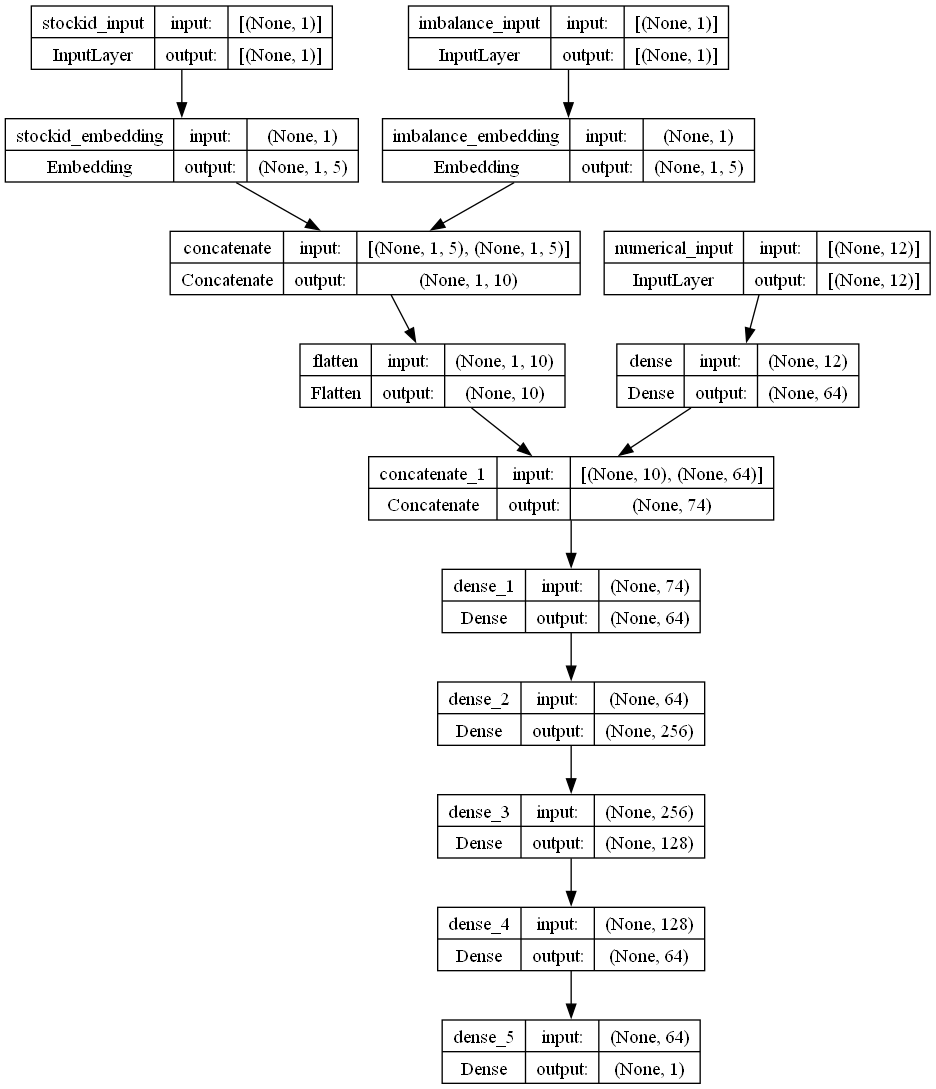

In [15]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [43]:
history = model.fit(
    x={
        'stockid_input': x_cat['stock_id'].values,
        'imbalance_input': x_cat['imbalance_buy_sell_flag'].values,
        'numerical_input': x_num.values
    },
    # y=y['target'].values,
    y=y.values,
    epochs=10,
    batch_size=1024
    # validation_split=0.2
)


Epoch 1/10
5083/5083 [==============================] - 44s 8ms/step - loss: 89.3701 - mae: 6.4073 - mean_squared_error: 89.3701
Epoch 2/10
5083/5083 [==============================] - 43s 8ms/step - loss: 89.3688 - mae: 6.4072 - mean_squared_error: 89.3688
Epoch 3/10
5083/5083 [==============================] - 44s 9ms/step - loss: 89.3687 - mae: 6.4072 - mean_squared_error: 89.3687
Epoch 4/10
5083/5083 [==============================] - 39s 8ms/step - loss: 89.3688 - mae: 6.4072 - mean_squared_error: 89.3688
Epoch 5/10
5083/5083 [==============================] - 38s 8ms/step - loss: 89.3688 - mae: 6.4072 - mean_squared_error: 89.3688
Epoch 6/10
5083/5083 [==============================] - 38s 8ms/step - loss: 89.3690 - mae: 6.4072 - mean_squared_error: 89.3690
Epoch 7/10
5083/5083 [==============================] - 39s 8ms/step - loss: 89.3692 - mae: 6.4073 - mean_squared_error: 89.3692
Epoch 8/10
5083/5083 [==============================] - 39s 8ms/step - loss: 89.3688 - mae: 6.407

In [44]:
# Save the training history to a file
import pickle

with open('FFN_MLP_unscaled.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [45]:
model_name.append('FFN_MLP')
model_list.append(model)
train_mse.append(history.history['mean_squared_error'][-1])
train_mae.append(history.history['mae'][-1])


In [46]:
mse = model.evaluate(x={
        'stockid_input': x_test['stock_id'].values,
        'imbalance_input': x_test['imbalance_buy_sell_flag'].values,
        'numerical_input': x_test_num.values
    },
    y=y_test['target'].values
)

1032/1032 [==============================] - 2s 2ms/step - loss: 87.3930 - mae: 6.4508 - mean_squared_error: 87.3930


In [47]:
test_mse.append(mse[2])
test_mae.append(mse[1])

In [48]:
df_results = pd.DataFrame({'Name':model_name,'Model':model_list,'test_mse':test_mse,'test_mae':test_mae,'train_mse':train_mse,'train_mae':train_mae})
df_results

,Name,Model,test_mse,test_mae,train_mse,train_mae
0,FFN_MLP,<keras.src.engine.functional.Functional object...,87.39296,6.450849,89.369049,6.407255


### LSTM

In [49]:
x_lstm = df.copy()
x_lstm = data_preprocessing(x_lstm)

x_lstm['imbalance_buy_sell_flag']=df['imbalance_buy_sell_flag']
x_lstm['target'] = df['target']


In [50]:
from sklearn.preprocessing import StandardScaler
def data_preprocessing_lstm(x,test_train):
    
    for i in x.columns:
        if x[i].isnull().sum()>0:
            x[i].fillna(x[i].mean(),inplace=True)

    seconds = x['seconds_in_bucket']
    x = x.drop(['seconds_in_bucket'],axis=1)      
    # Extract and encode catagorical columns
    categorical_cols = ['stock_id', 'imbalance_buy_sell_flag']
    x_cat = x[categorical_cols]

    for col in categorical_cols:
        x_cat[col] = x_cat[col].astype('category').cat.codes

    # Scale numeric columns
    target = x['target']
    x = x.drop(['target'],axis=1)  
    x_num = x.drop(categorical_cols, axis=1)
    scaler = StandardScaler()
    x_num = pd.DataFrame(scaler.fit_transform(x_num),columns=x_num.columns)
    x_num['date_id'] = x['date_id']

    # Conct back into single DF
    x = pd.concat([x_cat, x_num,seconds,target], axis=1)
    x_test = x[x['date_id']>=test_train]
    # x_test.drop(['date_id'],axis=1,inplace=True)
    x_test = x_test.dropna()

    x_train = x[x['date_id']<test_train]
    # x_train.drop(['date_id'],axis=1,inplace=True)
    x_train = x_train.dropna()
    return x_test, x_train

In [51]:

x_test_lstm,x_lstm=data_preprocessing_lstm(x_lstm,478)
y_lstm=x_lstm[['stock_id','date_id','target']]
x_lstm=x_lstm.drop(['target'],axis=1)

y_test_lstm=x_test_lstm[['stock_id','date_id','target']]
x_test_lstm=x_test_lstm.drop(['target'],axis=1)

x_lstm

,stock_id,imbalance_buy_sell_flag,date_id,reference_price,far_price,near_price,bid_price,ask_price,wap,imbalance_ratio,bid_ask_volume_diff,mid_price,bid_plus_ask_sizes,rolling_avg,seconds_in_bucket
0,0,2,0,-0.013518,0.187498,0.116604,0.045703,0.042625,0.094031,0.083527,-0.659207,0.044221,-0.049750,0.000985,0
1,0,0,0,0.113975,0.187498,0.116604,0.045703,0.042625,0.029652,-0.355325,0.087286,0.044221,-0.349029,0.000985,10
2,0,0,0,0.050229,0.187498,0.116604,0.045703,-0.021117,-0.000153,-0.355325,0.062396,0.012269,-0.545073,0.000985,20
3,0,0,0,0.177722,0.187498,0.116604,0.173498,0.106367,0.144700,-0.355325,-0.146501,0.140079,0.263040,0.000985,30
4,0,0,0,0.369557,0.187498,0.116604,0.301890,0.298188,0.282996,-0.371923,0.116717,0.300438,-0.313539,0.000985,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237810,199,2,477,-1.697232,-0.404973,-0.397527,-1.634065,-1.652670,-1.674968,-0.478044,1.087175,-1.643873,0.700725,-2.024611,500
5237811,199,2,477,-1.697232,-0.404973,-0.397527,-1.634065,-1.652670,-1.655608,-0.478044,0.602714,-1.643873,0.972473,-2.008218,510
5237812,199,0,477,-1.697232,-0.404973,-0.397527,-1.634065,-1.652670,-1.614121,-0.484307,-0.820773,-1.643873,1.065029,-1.975430,520
5237813,199,1,477,-1.550818,-0.404973,-0.397527,-1.486084,-1.504221,-1.477677,-0.475603,-0.452300,-1.495613,1.149836,-1.942693,530


In [52]:
# Group by 'stock_id' and aggregate the data
aggregated_df = x_lstm.groupby(['stock_id','date_id']).agg({
    # 'time_id': list,
    'imbalance_buy_sell_flag': list,
    'reference_price': list,
    'near_price':list,
    'bid_price': list,
    'ask_price': list,
    'wap': list,
    'imbalance_ratio': list,
    'bid_ask_volume_diff': list,
    'mid_price': list,
    'bid_plus_ask_sizes': list,
    'rolling_avg':list
}).reset_index()

# Name Columns
aggregated_df.columns = [
    'stock_id',
    'date_id',
    'imbalance_buy_sell_flag',
    'reference_price',
    'near_price',
    'bid_price',
    'ask_price',
    'wap',
    'imbalance_ratio',
    'bid_ask_volume_diff',
    'mid_price',
    'bid_plus_ask_sizes',
    'rolling_avg'
]

# Display the resulting DataFrame
aggregated_df


# Group by 'stock_id' and aggregate the data
aggregated_df_test = x_test_lstm.groupby(['stock_id','date_id']).agg({
    'imbalance_buy_sell_flag': list,
    'reference_price': list,
    'near_price':list,
    'bid_price': list,
    'ask_price': list,
    'wap': list,
    'imbalance_ratio': list,
    'bid_ask_volume_diff': list,
    'mid_price': list,
    'bid_plus_ask_sizes': list,
    'rolling_avg':list
}).reset_index()

# Name Columns
aggregated_df_test.columns = [
    'stock_id',
    'date_id',
    'imbalance_buy_sell_flag',
    'reference_price',
    'near_price',
    'bid_price',
    'ask_price',
    'wap',
    'imbalance_ratio',
    'bid_ask_volume_diff',
    'mid_price',
    'bid_plus_ask_sizes',
    'rolling_avg'
]

# Display the resulting DataFrame
aggregated_df


,stock_id,date_id,imbalance_buy_sell_flag,reference_price,near_price,bid_price,ask_price,wap,imbalance_ratio,bid_ask_volume_diff,mid_price,bid_plus_ask_sizes,rolling_avg
0,0,0,"[2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2, ...","[-0.013518013467926113, 0.1139751952776802, 0....","[0.11660420822758485, 0.11660420822758485, 0.1...","[0.04570299337989906, 0.04570299337989906, 0.0...","[0.04262499056968599, 0.04262499056968599, -0....","[0.09403136162788443, 0.02965227215312312, -0....","[0.08352677595416498, -0.3553248129939327, -0....","[-0.659206759805858, 0.08728586711367804, 0.06...","[0.04422114637521803, 0.04422114637521803, 0.0...","[-0.04975003813665127, -0.34902943163984274, -...","[0.0009847143201529376, 0.0009847143201529376,..."
1,0,1,"[0, 2, 2, 0, 0, 1, 0, 0, 0, 2, 2, 1, 2, 2, 1, ...","[0.052611641535604825, -0.3316552726742021, -0...","[0.11660420822758485, 0.11660420822758485, 0.1...","[-0.08030055169027307, -0.4009825597597541, -0...","[0.6216634941698658, -0.2748930366103264, -0.7...","[0.09403136162788443, -0.3977533496376461, -0....","[0.4479381628461593, -0.05713744885976684, -0....","[0.14129715314429359, 0.15556121858884098, 0.5...","[0.2714718365262658, -0.33831253835989716, -0....","[-0.3956418517832017, -0.40745647695071546, -0...","[0.0009847143201529376, 0.0009847143201529376,..."
2,0,2,"[0, 1, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, ...","[0.07942096113161479, -0.04985953558704563, -0...","[0.11660420822758485, 0.11660420822758485, 0.1...","[0.13886201248384128, 0.009275428217391699, -0...","[0.1373442519610881, -0.056860019822545564, -0...","[0.09403136162788443, -0.04188004948550793, -0...","[-0.6003536761103558, -0.6003536761103558, -0....","[0.20411974697609628, 0.1493872761092409, -0.3...","[0.1382868065559971, -0.023864474327014683, -0...","[-0.44581187820112345, -0.4729257810781299, -0...","[0.0009847143201529376, 0.0009847143201529376,..."
3,0,3,"[0, 0, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, ...","[0.23670230276169868, 0.04307943901256142, 0.0...","[0.11660420822758485, 0.11660420822758485, 0.1...","[0.1024344473214002, 0.1024344473214002, 0.037...","[0.2302763574770635, 0.03607208569356206, -0.0...","[0.09403136162788443, 0.048727557923442376, 0....","[0.8142472718070685, 0.7562504255005184, 0.756...","[0.2689661120499868, 0.42838124258913063, 0.18...","[0.1666558151819274, 0.06930532242347882, 0.00...","[-0.2974143346589889, -0.18149889647204492, 0....","[0.0009847143201529376, 0.0009847143201529376,..."
4,0,4,"[2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 1, 2, ...","[0.23670230276169868, 0.052611641535604825, 0....","[0.11660420822758485, 0.11660420822758485, 0.1...","[0.11198921851156173, 0.11198921851156173, 0.4...","[0.22670204572647445, 0.1653430273408783, 0.47...","[0.09403136162788443, 0.14112347337327738, 0.4...","[0.6833312430184652, 0.4795753640653023, 0.495...","[1.8744443399440849, -0.03141227373505295, -0....","[0.1696420266162568, 0.13888404884280994, 0.47...","[1.6703679244142875, -0.33391391028401796, -0....","[0.0009847143201529376, 0.0009847143201529376,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94631,199,473,"[0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 1, ...","[0.040527050203469785, -0.11137818426703502, -...","[0.0030788408958279776, 0.0030788408958279776,...","[-0.18431600414917101, -0.18431600414917101, -...","[-0.044247182796318105, -0.1977826353624914, -...","[-0.04408987576947732, -0.1293675700737717, -0...","[-0.5431602241795838, -0.5431602241795838, -0....","[-0.6654650866951137, -1.1771200836556426, -0....","[-0.11431801514472575, -0.19110802607683566, -...","[0.10083204579730044, 0.13308012556855353, 0.4...","[0.0009847143201529376, 0.0009847143201529376,..."
94632,199,474,"[0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 0, 2, ...","[-0.11503855136271474, 0.34708279446641693, 0....","[0.0030788408958279776, 0.0030788408958279776,...","[-0.034947918778167865, 0.276274129069207, 0.5...","[0.26559845943078125, 0.26559845943078125, 0.5...","[-0.04408987576947732, 

In [53]:
# Group by 'stock_id' and aggregate the data
aggregated_df_y = y_lstm.groupby(['stock_id','date_id']).agg({
    'target': list,
}).reset_index()

# Name Columns
aggregated_df_y.columns = [
    'stock_id',
    'date_id',
    'target'
]

aggregated_df_y_test = y_test_lstm.groupby(['stock_id','date_id']).agg({
    'target': list,
}).reset_index()

# Name Columns
aggregated_df_y_test.columns = [
    'stock_id',
    'date_id',
    'target'
]

# Display the resulting DataFrame
aggregated_df_y


,stock_id,date_id,target
0,0,0,"[-3.029704, -5.519986, -8.38995, -4.0102005, -..."
1,0,1,"[-1.2099743, 10.479689, 6.8295, -1.2797117, -3..."
2,0,2,"[-2.9802322, -5.350113, 3.399849, 2.6202202, -..."
3,0,3,"[-1.4799833, 19.199848, 3.3795834, 10.509491, ..."
4,0,4,"[-6.7299604, -0.83982944, -14.8797035, 0.77009..."
...,...,...,...
94631,199,473,"[2.5498867, 0.6496906, 0.95009804, -1.8000603,..."
94632,199,474,"[-2.6601553, -1.1301041, 5.02944, 0.33974648, ..."
94633,199,475,"[3.0100346, -0.0500679, 4.2295456, 8.569956, 4..."
94634,199,476,"[0.44941902, -3.4600496, -2.8198957, 2.6595592..."


In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam

embedding_dim = 5
# Categorical inputs
vocab_size_cat1 = len(x_lstm['stock_id'].unique())
# vocab_size_cat3 = len(x_lstm['time_id'].unique())
vocab_size_cat2 = len(x_lstm['date_id'].unique())
output_size = len(aggregated_df['imbalance_buy_sell_flag'][0])

input_cat1 = Input(shape=(1,), name='stockid_input')
emb1 = Embedding(input_dim=vocab_size_cat1, output_dim=embedding_dim, input_length=1, name='stockid_embedding')(input_cat1)

input_cat2 = Input(shape=(1,), name='dateid_input')
emb2 = Embedding(input_dim=vocab_size_cat2, output_dim=embedding_dim, input_length=1, name='dateid_embedding')(input_cat2)

# Concatenate Categorical Inputs
concatenated_cat = Concatenate()([emb1,emb2])

flat_emb1 = Dense(10,activation = 'relu')(Flatten()(concatenated_cat))

# Sequential data inputs
reference_price_input = Input(shape=(output_size, 1), name='reference_price_input')  # Sequence input
lstm1 = LSTM(64, activation='tanh')(reference_price_input)

imbalance_embedding_input = Input(shape=(output_size, 1), name='imbalance_embedding_input')  # Sequence input
lstm9 = LSTM(64, activation='tanh')(imbalance_embedding_input)
                                   
bid_price_input = Input(shape=(output_size, 1), name='bid_price_input')  # Sequence input
lstm2 = LSTM(64, activation='tanh')(bid_price_input)

ask_price_input = Input(shape=(output_size, 1), name='ask_price_input')  # Sequence input
lstm3 = LSTM(64, activation='tanh')(ask_price_input)

wap_input = Input(shape=(output_size, 1), name='wap_input')  # Sequence input
lstm4 = LSTM(64, activation='tanh')(wap_input)

imbalance_ratio_input = Input(shape=(output_size, 1), name='imbalance_ratio_input')  # Sequence input
lstm5 = LSTM(64, activation='tanh')(imbalance_ratio_input)

bid_ask_volume_diff_input = Input(shape=(output_size, 1), name='bid_ask_volume_diff_input')  # Sequence input
lstm6 = LSTM(64, activation='tanh')(bid_ask_volume_diff_input)

mid_price_input = Input(shape=(output_size, 1), name='mid_price_input')  # Sequence input
lstm7 = LSTM(64, activation='tanh')(mid_price_input)

bid_plus_ask_sizes_input = Input(shape=(output_size, 1), name='bid_plus_ask_sizes_input')  # Sequence input
lstm8 = LSTM(64, activation='tanh')(bid_plus_ask_sizes_input)

near_price_input = Input(shape=(output_size, 1), name='near_price_input')  # Sequence input
lstm10 = LSTM(64, activation='tanh')(near_price_input)

rolling_average_input = Input(shape=(output_size, 1), name='rolling_average_input')  # Sequence input
lstm11 = LSTM(64, activation='tanh')(rolling_average_input)

# Concatenate all sequential inputs
concatenated_lstm = Concatenate()([lstm1, lstm9, lstm2, lstm3, lstm4, lstm5, lstm6, lstm7, lstm8,lstm10,lstm11])
flat_lstm = Flatten()(concatenated_lstm)

#Concatenate categorical and sequential inputs
concatenated_all = Concatenate()([flat_emb1,flat_lstm])

# Additional dense layers
dense_1 = Dense(64, activation='relu')(concatenated_all)
dense_2 = Dense(32, activation='relu')(dense_1)

# Output layer
output = Dense(output_size, activation='linear', name='output')(dense_2)

# Create the model
model = Model(inputs=[input_cat1, input_cat2, reference_price_input, imbalance_embedding_input,bid_price_input, ask_price_input, wap_input, imbalance_ratio_input, bid_ask_volume_diff_input, mid_price_input, bid_plus_ask_sizes_input,near_price_input,rolling_average_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 stockid_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 dateid_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 stockid_embedding (Embeddi  (None, 1, 5)                 1000      ['stockid_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 dateid_embedding (Embeddin  (None, 1, 5)                 2390      ['dateid_input[0][0]']  

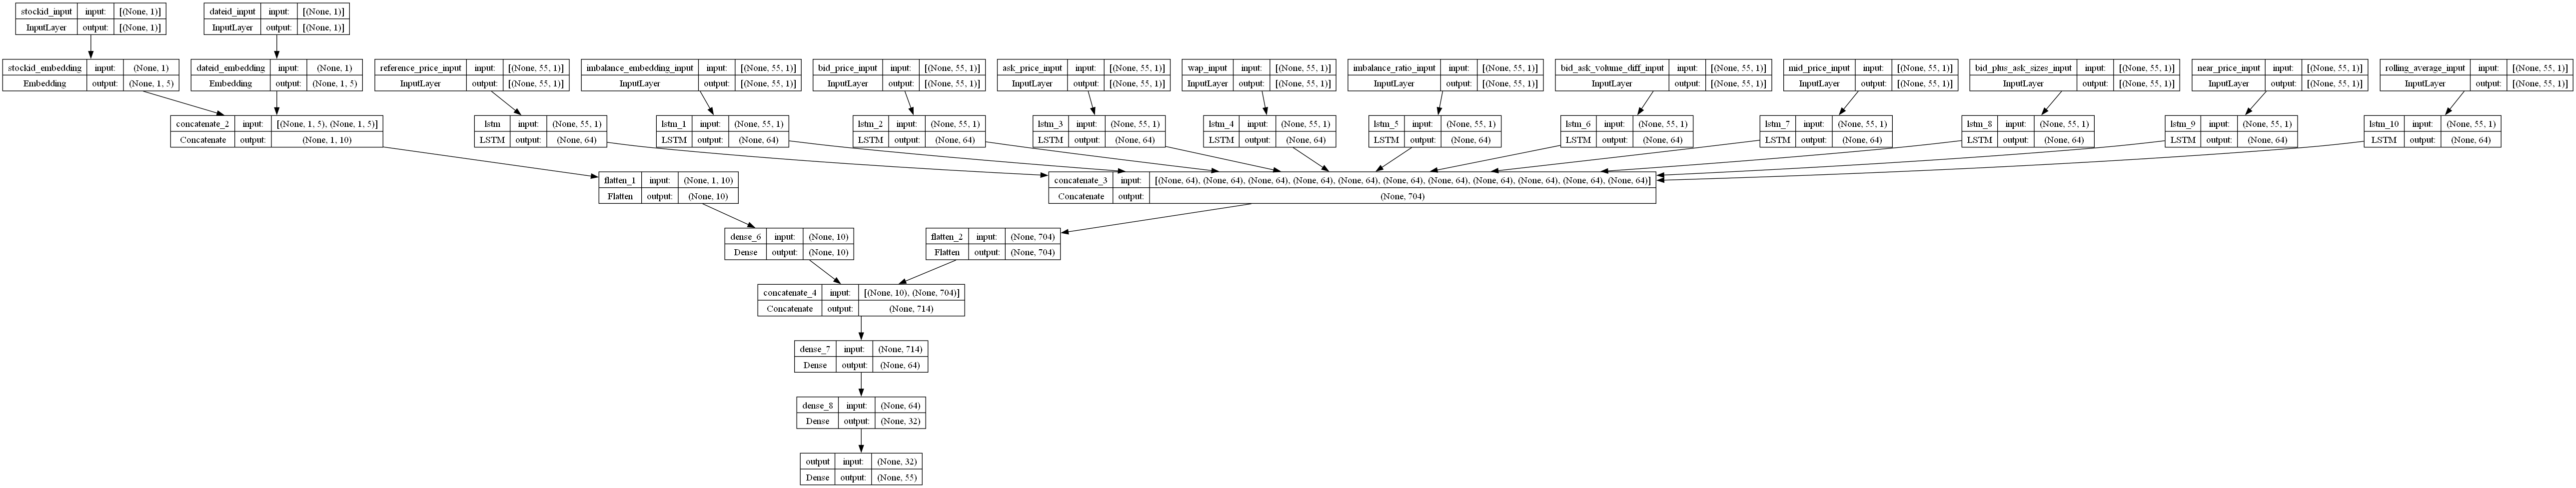

In [22]:
from tensorflow.keras.utils import plot_model

# ... (your existing code)

# Plot the model
plot_model(model, to_file='model_plot_lstm.png', show_shapes=True, show_layer_names=True)


In [58]:
cols = ['reference_price',	'imbalance_buy_sell_flag','bid_price',	'ask_price',	'wap',	'imbalance_ratio',	'bid_ask_volume_diff',	'mid_price',	'bid_plus_ask_sizes','near_price','rolling_avg']

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='mae',  # or another metric like 'val_accuracy'
                               patience=5,          # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
                               verbose=1)

history = model.fit([aggregated_df['stock_id'].values,aggregated_df['date_id'].values, [np.stack(aggregated_df[col].values) for col in cols]],
    y=(np.stack(aggregated_df_y['target'].values)),
    epochs=10,
    batch_size=1024,
    callbacks=[early_stopping]
    # validation_split=0.2
)

Epoch 1/10
93/93 [==============================] - 838s 9s/step - loss: 89.3703 - mae: 6.4074
Epoch 2/10
93/93 [==============================] - 986s 11s/step - loss: 89.3680 - mae: 6.4073
Epoch 3/10
93/93 [==============================] - 953s 10s/step - loss: 89.3671 - mae: 6.4072
Epoch 4/10
93/93 [==============================] - 933s 10s/step - loss: 89.3664 - mae: 6.4072
Epoch 5/10
93/93 [==============================] - 927s 10s/step - loss: 89.3646 - mae: 6.4071
Epoch 6/10
93/93 [==============================] - 916s 10s/step - loss: 89.3523 - mae: 6.4064
Epoch 7/10
93/93 [==============================] - 1057s 11s/step - loss: 89.3238 - mae: 6.4051
Epoch 8/10
93/93 [==============================] - 1415s 15s/step - loss: 89.3042 - mae: 6.4043
Epoch 9/10
93/93 [==============================] - 915s 10s/step - loss: 89.2942 - mae: 6.4040
Epoch 10/10
93/93 [==============================] - 918s 10s/step - loss: 89.2857 - mae: 6.4037


In [59]:
# Save the training history to a file
import pickle

with open('training_history_lstm_unscaled.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [60]:
model_name.append('LSTM NN')
model_list.append(model)
train_mse.append(history.history['loss'][-1])
train_mae.append(history.history['mae'][-1])

In [61]:
# Set date labels
aggregated_df_test['date_id'] = aggregated_df_test['date_id'].astype('category').cat.codes

In [62]:


mse = model.evaluate([aggregated_df_test['stock_id'].values,aggregated_df_test['date_id'].values, [np.stack(aggregated_df_test[col].values) for col in cols]],
y=(np.stack(aggregated_df_y_test['target'].values)))


19/19 [==============================] - 7s 63ms/step - loss: 87.4201 - mae: 6.4520


In [63]:
test_mse.append(mse[0])
test_mae.append(mse[1])

In [64]:
df_results = pd.DataFrame({'Name':model_name,'Model':model_list,'test_mse':test_mse,'test_mae':test_mae,'train_mse':train_mse,'train_mae':train_mae})
df_results

,Name,Model,test_mse,test_mae,train_mse,train_mae
0,FFN_MLP,<keras.src.engine.functional.Functional object...,87.392960,6.450849,89.369049,6.407255
1,LSTM NN,<keras.src.engine.functional.Functional object...,87.420105,6.451977,89.285706,6.403691


In [65]:
df_results.to_csv('Results_NN_unscaled.csv')

In [66]:
df_results

,Name,Model,test_mse,test_mae,train_mse,train_mae
0,FFN_MLP,<keras.src.engine.functional.Functional object...,87.392960,6.450849,89.369049,6.407255
1,LSTM NN,<keras.src.engine.functional.Functional object...,87.420105,6.451977,89.285706,6.403691
